In [36]:
import os
import pandas as pd
import dask.dataframe as dd
import numpy as np
import matplotlib.pyplot as plt

## KWNLP dataset

- Developed by Kensho
- Anchored Texts & Corresponding Wikidata URLs

In [11]:
my_path = '../../kwnlp/'
article_df = pd.read_csv(os.path.join(my_path, 'article.csv'))
article_df.head()

,page_id,item_id,page_title,views,len_article_chars,len_intro_chars,in_link_count,out_link_count,tmpl_good_article,tmpl_featured_article,tmpl_pseudoscience,tmpl_conspiracy_theories,isa_Q17442446,isa_Q14795564,isa_Q18340514
0,12,6199,Anarchism,35558,40449,409,3826,371,1,0,0,0,0,0,0
1,25,38404,Autism,40081,47659,419,2313,309,0,1,0,0,0,0,0
2,39,101038,Albedo,10770,18766,293,3090,115,0,0,0,0,0,0,0
3,290,9659,A,29398,9538,609,173,149,0,0,0,0,0,0,0
4,303,173,Alabama,46680,74276,369,11864,744,0,0,0,0,0,0,0


In [12]:
len(article_df)

6189965

In [13]:
anchor_df = pd.read_csv(os.path.join(my_path, 'anchor_target_counts.csv'))
anchor_df.head()

,anchor_text,target_page_id,count
0,United States,3434750,152451
1,World War II,32927,133668
2,India,14533,112069
3,France,5843419,109669
4,footballer,10568,101027


In [14]:
len(anchor_df)

15269229

In [19]:
at_count_df = anchor_df.copy()

In [22]:
def text_normalizer(text):                              
    """Return text after stripping external whitespace and lower casing."""   
    return str(text).strip().lower()

at_count_df["normalized_anchor_text"] = at_count_df["anchor_text"].apply(text_normalizer)
at_count_df = at_count_df.loc[at_count_df['normalized_anchor_text'].str.len() > 0, :]

In [24]:
at_count_df

,anchor_text,target_page_id,count,normalized_anchor_text
0,United States,3434750,152451,united states
1,World War II,32927,133668,world war ii
2,India,14533,112069,india
3,France,5843419,109669,france
4,footballer,10568,101027,footballer
...,...,...,...,...
15269224,Sheldon,1299850,1,sheldon
15269225,Korunamoyee Rani Rashmoni,59216176,1,korunamoyee rani rashmoni
15269226,Musik-Lexikon,64672172,1,musik-lexikon
15269227,Su-27,2733709,1,su-27


In [25]:
at_count_df = pd.merge(
    at_count_df,
    article_df,
    how="inner",
    left_on="target_page_id",
    right_on="page_id")

In [29]:
at_count_df = at_count_df.rename(columns={
    'title': 'target_page_title',
    'item_id': 'target_item_id',
    'views': 'target_page_views',
    'count': 'anchor_target_count',
    'page_title': 'target_page_title'})

In [30]:
at_count_df.head()

,anchor_text,target_page_id,anchor_target_count,normalized_anchor_text,page_id,target_item_id,target_page_title,target_page_views,len_article_chars,len_intro_chars,in_link_count,out_link_count,tmpl_good_article,tmpl_featured_article,tmpl_pseudoscience,tmpl_conspiracy_theories,isa_Q17442446,isa_Q14795564,isa_Q18340514
0,United States,3434750,152451,united states,3434750,30,United_States,460156,78654,527,250765,1144,0,0,0,0,0,0,0
1,American,3434750,65722,american,3434750,30,United_States,460156,78654,527,250765,1144,0,0,0,0,0,0,0
2,USA,3434750,8559,usa,3434750,30,United_States,460156,78654,527,250765,1144,0,0,0,0,0,0,0
3,U.S.,3434750,7633,u.s.,3434750,30,United_States,460156,78654,527,250765,1144,0,0,0,0,0,0,0
4,US,3434750,5288,us,3434750,30,United_States,460156,78654,527,250765,1144,0,0,0,0,0,0,0


In [31]:
at_count_df = at_count_df[[
    "normalized_anchor_text",
    "target_page_id",
    "target_item_id",
    "target_page_title",
    "target_page_views",
    "anchor_target_count"]]

In [32]:
at_count_df.head()

,normalized_anchor_text,target_page_id,target_item_id,target_page_title,target_page_views,anchor_target_count
0,united states,3434750,30,United_States,460156,152451
1,american,3434750,30,United_States,460156,65722
2,usa,3434750,30,United_States,460156,8559
3,u.s.,3434750,30,United_States,460156,7633
4,us,3434750,30,United_States,460156,5288


In [33]:
MIN_VIEWS = 5
MIN_ANCHOR_TARGET_COUNT = 2
NUM_KLAT_LINES = 5_343_564
NUM_PAGE_LINES = 5_362_174

bool_mask_1 = at_count_df["anchor_target_count"] >= MIN_ANCHOR_TARGET_COUNT
bool_mask_2 = at_count_df["target_page_views"] >= MIN_VIEWS
bool_mask = bool_mask_1 & bool_mask_2
at_count_df = at_count_df.loc[bool_mask, :].copy()

In [34]:
norm = at_count_df.groupby("target_page_id")["anchor_target_count"].transform("sum")
at_count_df["p_anchor_given_target"] = at_count_df["anchor_target_count"] / norm
norm = at_count_df.groupby("normalized_anchor_text")["anchor_target_count"].transform("sum")
at_count_df["p_target_given_anchor"] = at_count_df["anchor_target_count"] / norm

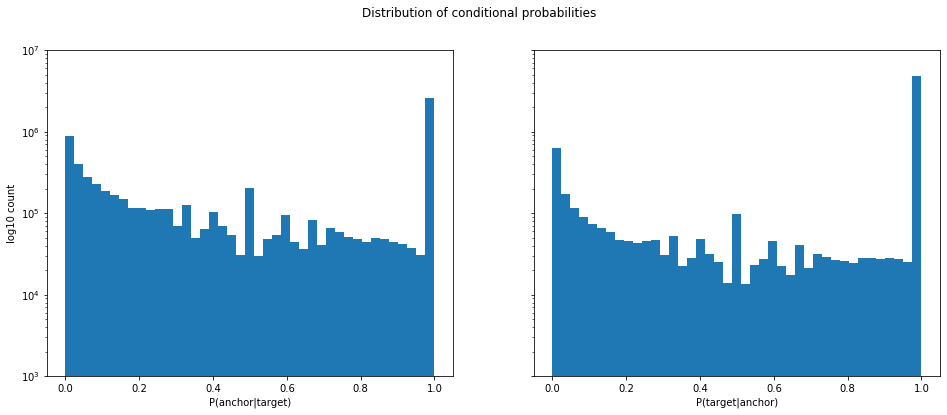

In [37]:
pagt = at_count_df['p_anchor_given_target'].values
ptga = at_count_df['p_target_given_anchor'].values

fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(16,6))
axes[0].hist(pagt, log=True, bins=41)
axes[0].set_xlabel('P(anchor|target)')
axes[0].set_ylabel('log10 count')
axes[0].set_ylim(1e3, 1e7)


axes[1].hist(ptga, log=True, bins=41)
axes[1].set_xlabel('P(target|anchor)')
axes[1].set_ylim(1e3, 1e7)

fig.suptitle('Distribution of conditional probabilities');

In [38]:
class AnchorTargetStats:
    
    def __init__(
        self,
        at_count_df,
        text_normalizer,
    ):
        """Anchor-target statistics 
        
        Args:
            at_count_df: (normalized_anchor_text, target_page) counts and metadata
            text_normalizer: text cleaning function for anchor texts
        """
        self._at_count_df = at_count_df
        self.text_normalizer = text_normalizer

    def get_aliases_from_page_id(self, page_id):
        """Return anchor strings used to refer to entity"""
        bool_mask = self._at_count_df['target_page_id'] == page_id
        return (
            self._at_count_df.
            loc[bool_mask].copy().
            sort_values('p_anchor_given_target', ascending=False)
        )
    def get_disambiguation_candidates_from_text(self, text):
        """Return candidate entities for input text"""
        normalized_text = self.text_normalizer(text)
        bool_mask = self._at_count_df['normalized_anchor_text'] == normalized_text
        return (
            self._at_count_df.
            loc[bool_mask].copy().
            sort_values('p_target_given_anchor', ascending=False)
        )

In [39]:
anchor_target_stats = AnchorTargetStats(at_count_df, text_normalizer)

In [40]:
page_id = 18717338   # https://en.wikipedia.org/wiki/United_States_dollar
aliases = anchor_target_stats.get_aliases_from_page_id(page_id)
aliases.head(25)

,normalized_anchor_text,target_page_id,target_item_id,target_page_title,target_page_views,anchor_target_count,p_anchor_given_target,p_target_given_anchor
64782,us$,18717338,4917,United_States_dollar,44241,6150,0.362703,0.998701
64783,$,18717338,4917,United_States_dollar,44241,4300,0.253598,0.779409
64784,usd,18717338,4917,United_States_dollar,44241,3083,0.181824,0.945416
64785,united states dollar,18717338,4917,United_States_dollar,44241,555,0.032732,0.960208
64786,us dollar,18717338,4917,United_States_dollar,44241,515,0.030373,0.908289
64787,us,18717338,4917,United_States_dollar,44241,315,0.018577,0.047468
64788,u.s. dollar,18717338,4917,United_States_dollar,44241,303,0.017870,0.938080
64789,dollars,18717338,4917,United_States_dollar,44241,301,0.017752,0.713270
64790,us dollars,18717338,4917,United_States_dollar,44241,285,0.016808,0.800562
64791,u.s. dollars,18717338,4917,United_States_dollar,44241,205,0.012090,0.976190
